In [1]:
import sys
sys.path.append('../src')

import numpy as np
import matplotlib.pyplot as plt
from PyAstronomy import pyasl
from datetime import datetime

from FIESTA_functions import *
from HARPS_N_functions import *
from NEID_solar_functions import *
from functions import *
#----------------------------------
# Read data
#----------------------------------


In [15]:
if 1:
    v_grid  = np.loadtxt('../lib/data_v4/v_grid.txt')
    CCF     = np.loadtxt('../lib/data_v4/CCF.txt')
    σCCF   = np.loadtxt('../lib/data_v4/σCCF.txt')
    bjd     = np.loadtxt('../lib/data_v4/bjd.txt')
    rv      = np.loadtxt('../lib/data_v4/rv.txt')
    σrv     = np.loadtxt('../lib/data_v4/σrv.txt')
    idx_rej = np.array(np.loadtxt('../lib/data_v4/idx_rej'), dtype=bool)
    
    # idx_v = (v_grid>90.25) & (v_grid<107.5)
    # v_grid = v_grid[idx_v]
    
    CCF = CCF[:,~idx_rej]
    σCCF = σCCF[:,~idx_rej]
    # CCF = CCF[idx_v,:]
    # σCCF = σCCF[idx_v,:]    
    bjd = bjd[~idx_rej]
    rv = rv[~idx_rej]
    σrv = σrv[~idx_rej]

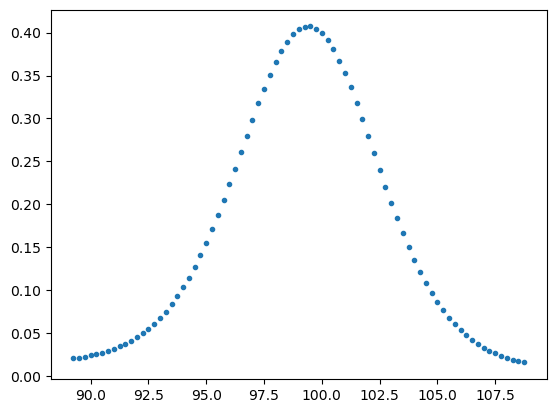

In [20]:
plt.plot(v_grid, CCF[:,0], '.')
plt.show()

In [18]:
t_min = int(min(bjd))
t_max = int(max(bjd))
N = t_max -t_min + 1


idx_v = (v_grid>89) & (v_grid<109)
v_grid = v_grid[idx_v]

CCF = CCF[idx_v,:]
σCCF = σCCF[idx_v,:]    





bjd_daily 			= np.zeros(N)
CCF_daily 			= np.zeros((len(v_grid), N))
σCCF_daily			= np.zeros((len(v_grid), N))
rv_daily			= np.zeros(N)
# rv_raw_daily		= np.zeros(N)
σrv_daily			= np.zeros(N)



for n in range(N):
    idx = (bjd>(t_min+n)) & (bjd<(t_min+n+0.5))
    if len(bjd[idx])!=0:
        bjd_daily[n] = weighted_avg_1D(bjd[idx], 1/σrv[idx]**2)
        rv_daily[n] =  weighted_avg_1D(rv[idx], 1/σrv[idx]**2)
        σrv_daily[n] = 1/np.sqrt(np.sum(1/σrv[idx]**2))
        CCF_daily[:,n] = 1-weighted_avg_2D(1-CCF[:,idx], 1/σrv[idx]**2)
        σCCF_daily[:,n] = 1/np.sqrt(np.sum(1/σCCF[:,idx]**2, axis=1))

idx_0 		= (rv_daily==0)
rv_daily 	= rv_daily[~idx_0]
# rv_raw_daily= rv_raw_daily[~idx_0]
σrv_daily 	= σrv_daily[~idx_0]
bjd_daily 	= bjd_daily[~idx_0]
CCF_daily 	= CCF_daily[:,~idx_0]
σCCF_daily 	= σCCF_daily[:,~idx_0]



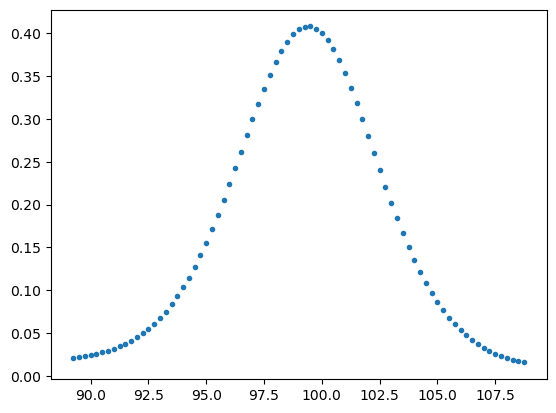

In [21]:
plt.plot(v_grid, CCF_daily[:,0], '.')
plt.show()

In [19]:
CCF_daily.shape

(79, 202)

In [22]:
np.median((1-CCF_daily) / σCCF_daily)

73594.06000926348

In [23]:
from scipy.interpolate import CubicSpline

# CCF_tpl = np.mean(CCF_daily, axis=1)
CCF_tpl = CCF_daily[:,0]
cs = CubicSpline(v_grid, CCF_tpl, extrapolate=True)

CCF_daily_sh = np.zeros(CCF_daily.shape)
σCCF_daily_sh = np.zeros(CCF_daily.shape)

shift = np.arange(202)/202/100
print(max(shift)*1000)
for i in range(202):
    CCF_daily_sh[:,i] = cs(v_grid-shift[i])
    σCCF_daily_sh[:,i] = (1-CCF_tpl)**0.5/7e4

9.950495049504951


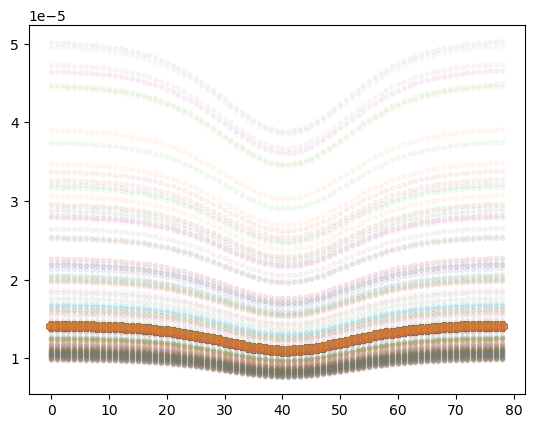

In [24]:
plt.plot(σCCF_daily_sh, 'o')
plt.plot(σCCF_daily, '.', alpha=0.05)
plt.show()

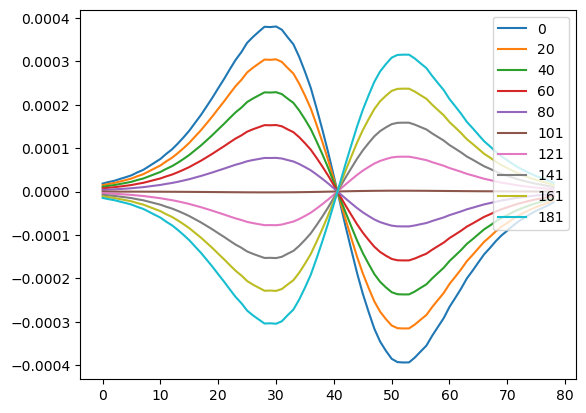

In [25]:
# plt.plot(CCF_daily_wn-np.mean(CCF_daily_wn, axis=1), '.')

# plt.plot(np.mean(CCF_daily_wn, axis=1), '.') 
for i in np.linspace(0,202,10, endpoint=False):
    i = int(i)
    plt.plot(CCF_daily_sh[:,i]-np.mean(CCF_daily_sh, axis=1), '-', label=str(i)) 
plt.legend(loc=1)    
plt.show()

In [26]:
CCF_daily_sh.shape

(79, 202)

In [27]:
k_max = 39
df, RV_FT_k, eRV_FT_k, A_k, eA_k, RV_gauss = FIESTA(v_grid, CCF_daily_sh, σCCF_daily_sh/10, k_max=k_max)

order_max = 39
RV_FIESTA = np.average(RV_FT_k[:order_max], axis=0, weights=A_k[:order_max])*1000
print(np.mean(A_k[order_max-1]))

RV_FT_k  *= 1000
eRV_FT_k *= 1000
RV_gauss *= 1000
ΔRV_k     = RV_FT_k - RV_FIESTA

0.002476551784880473


In [12]:
np.std(RV_gauss)

2.8873560994234424

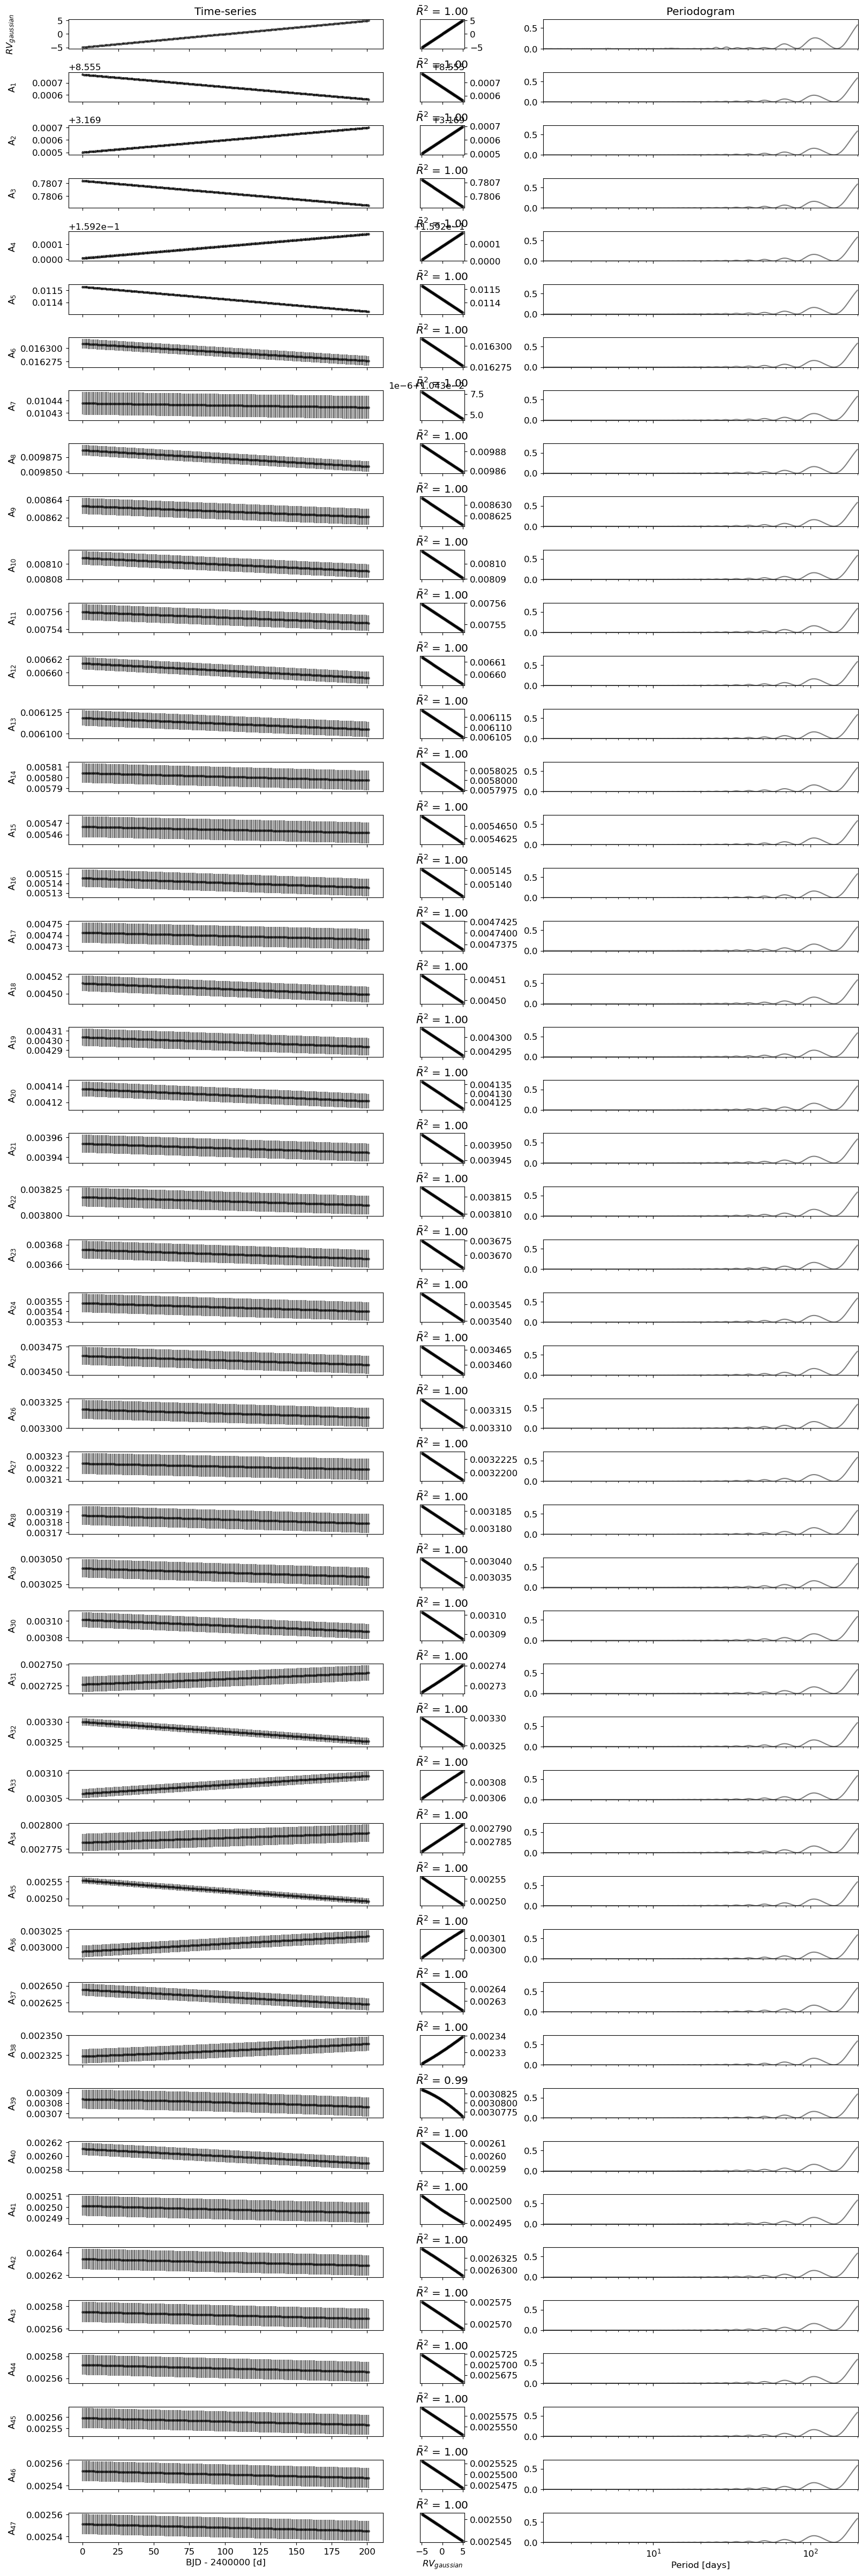

In [13]:
plot_all(k_mode=k_max, t=np.arange(202), rv=RV_gauss, erv=σrv_daily, 
    ind=A_k, eind=eA_k, 
    ts_xlabel='BJD - 2400000 [d]', 
    rv_xlabel='$RV_{gaussian}$', 
    pe_xlabel='Period [days]',
    ind_yalbel='A',
    file_name='',
    HARPS=False)
plt.show()

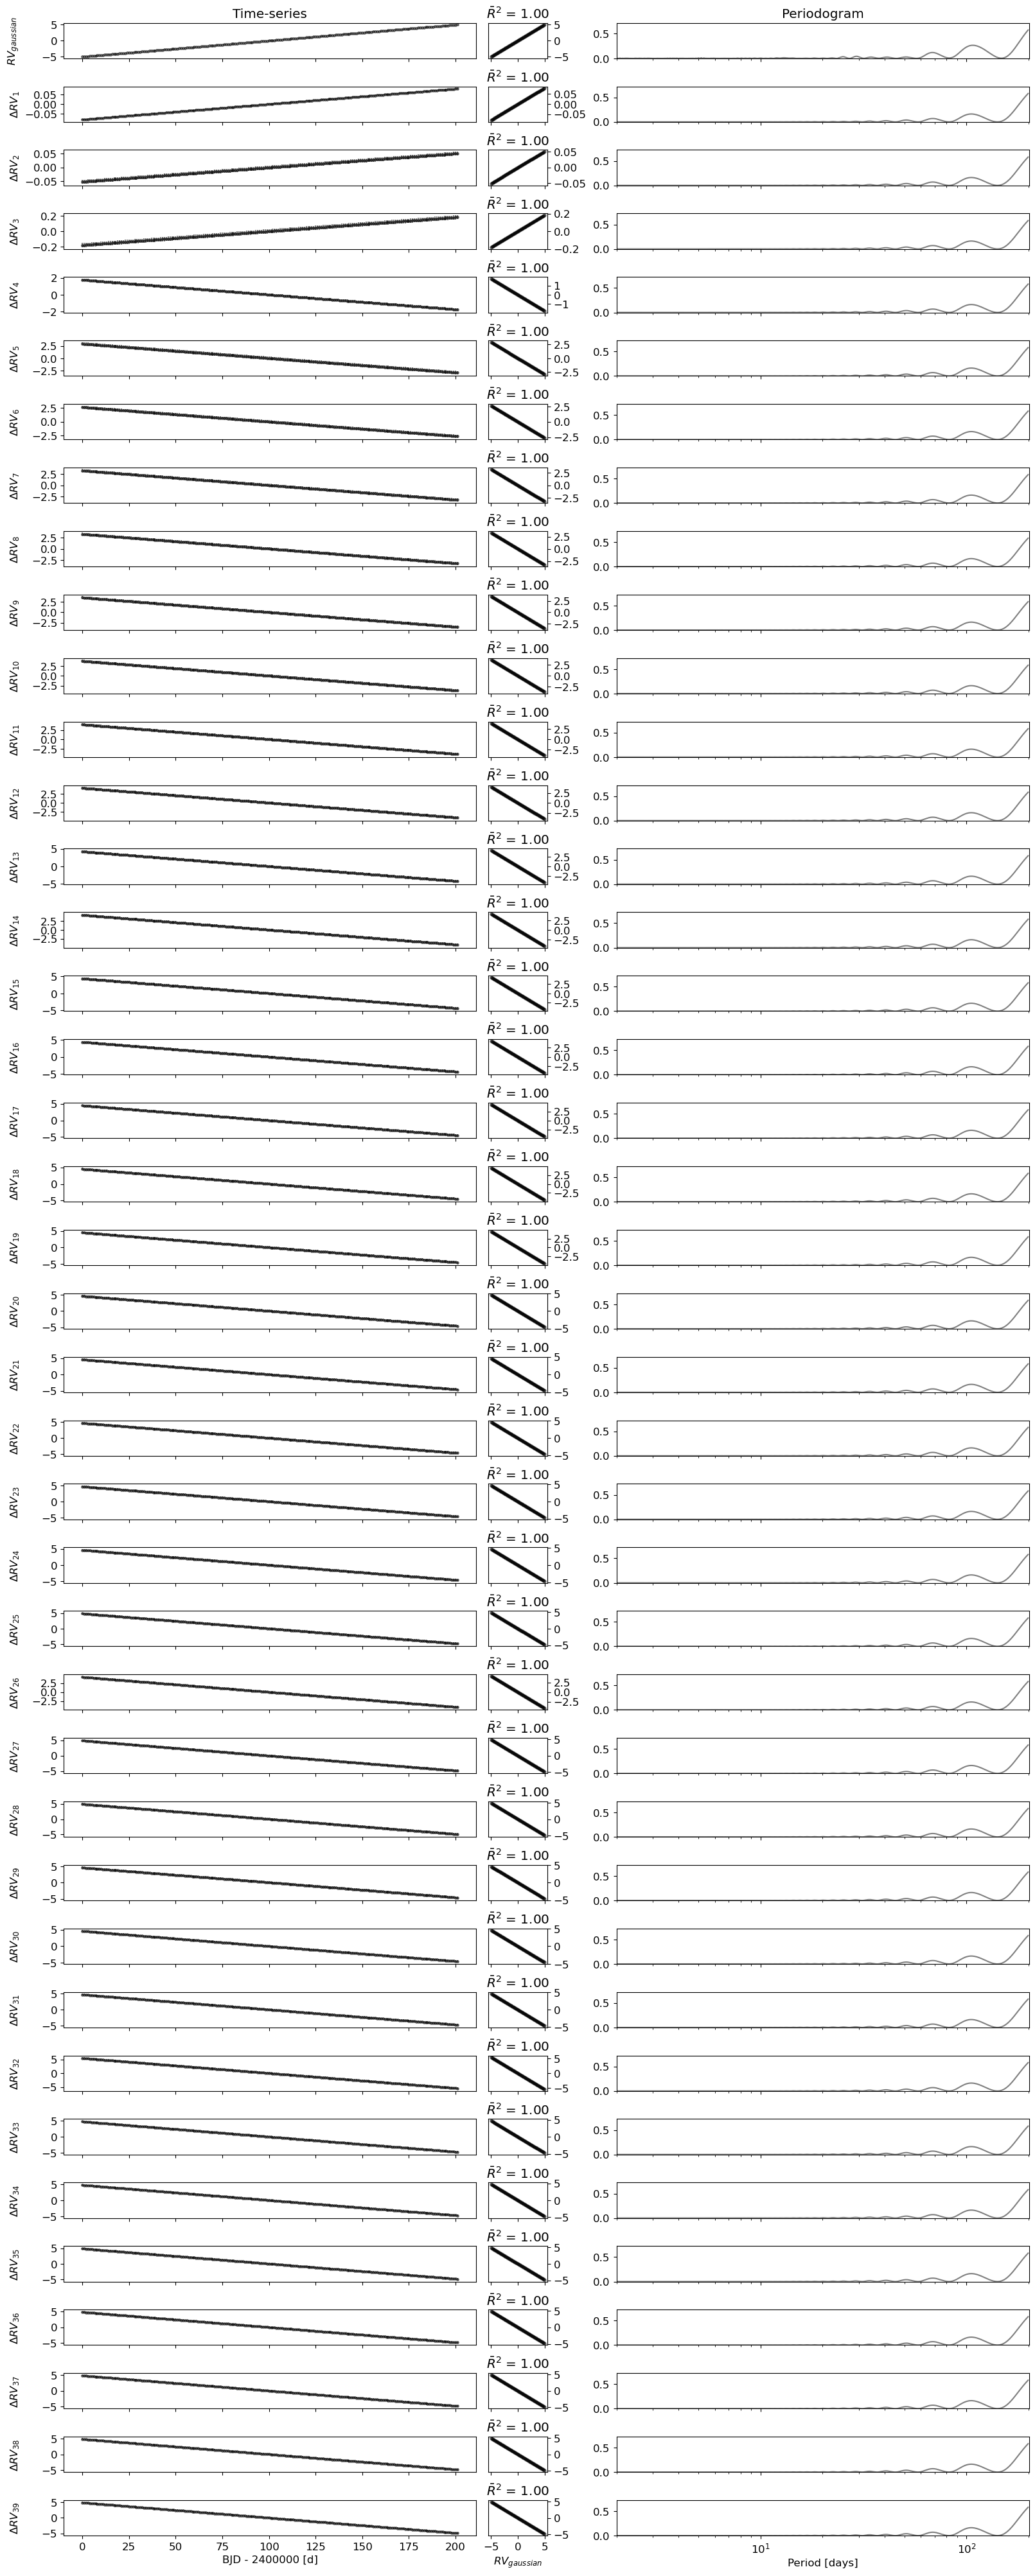

In [28]:
plot_all(k_mode=k_max, t=np.arange(202), rv=RV_gauss, erv=σrv_daily, 
    ind=ΔRV_k, eind=eRV_FT_k, 
    ts_xlabel='BJD - 2400000 [d]', 
    rv_xlabel='$RV_{gaussian}$', 
    pe_xlabel='Period [days]',
    ind_yalbel=r'$\Delta RV$',
    file_name='',
    HARPS=False)
plt.show()

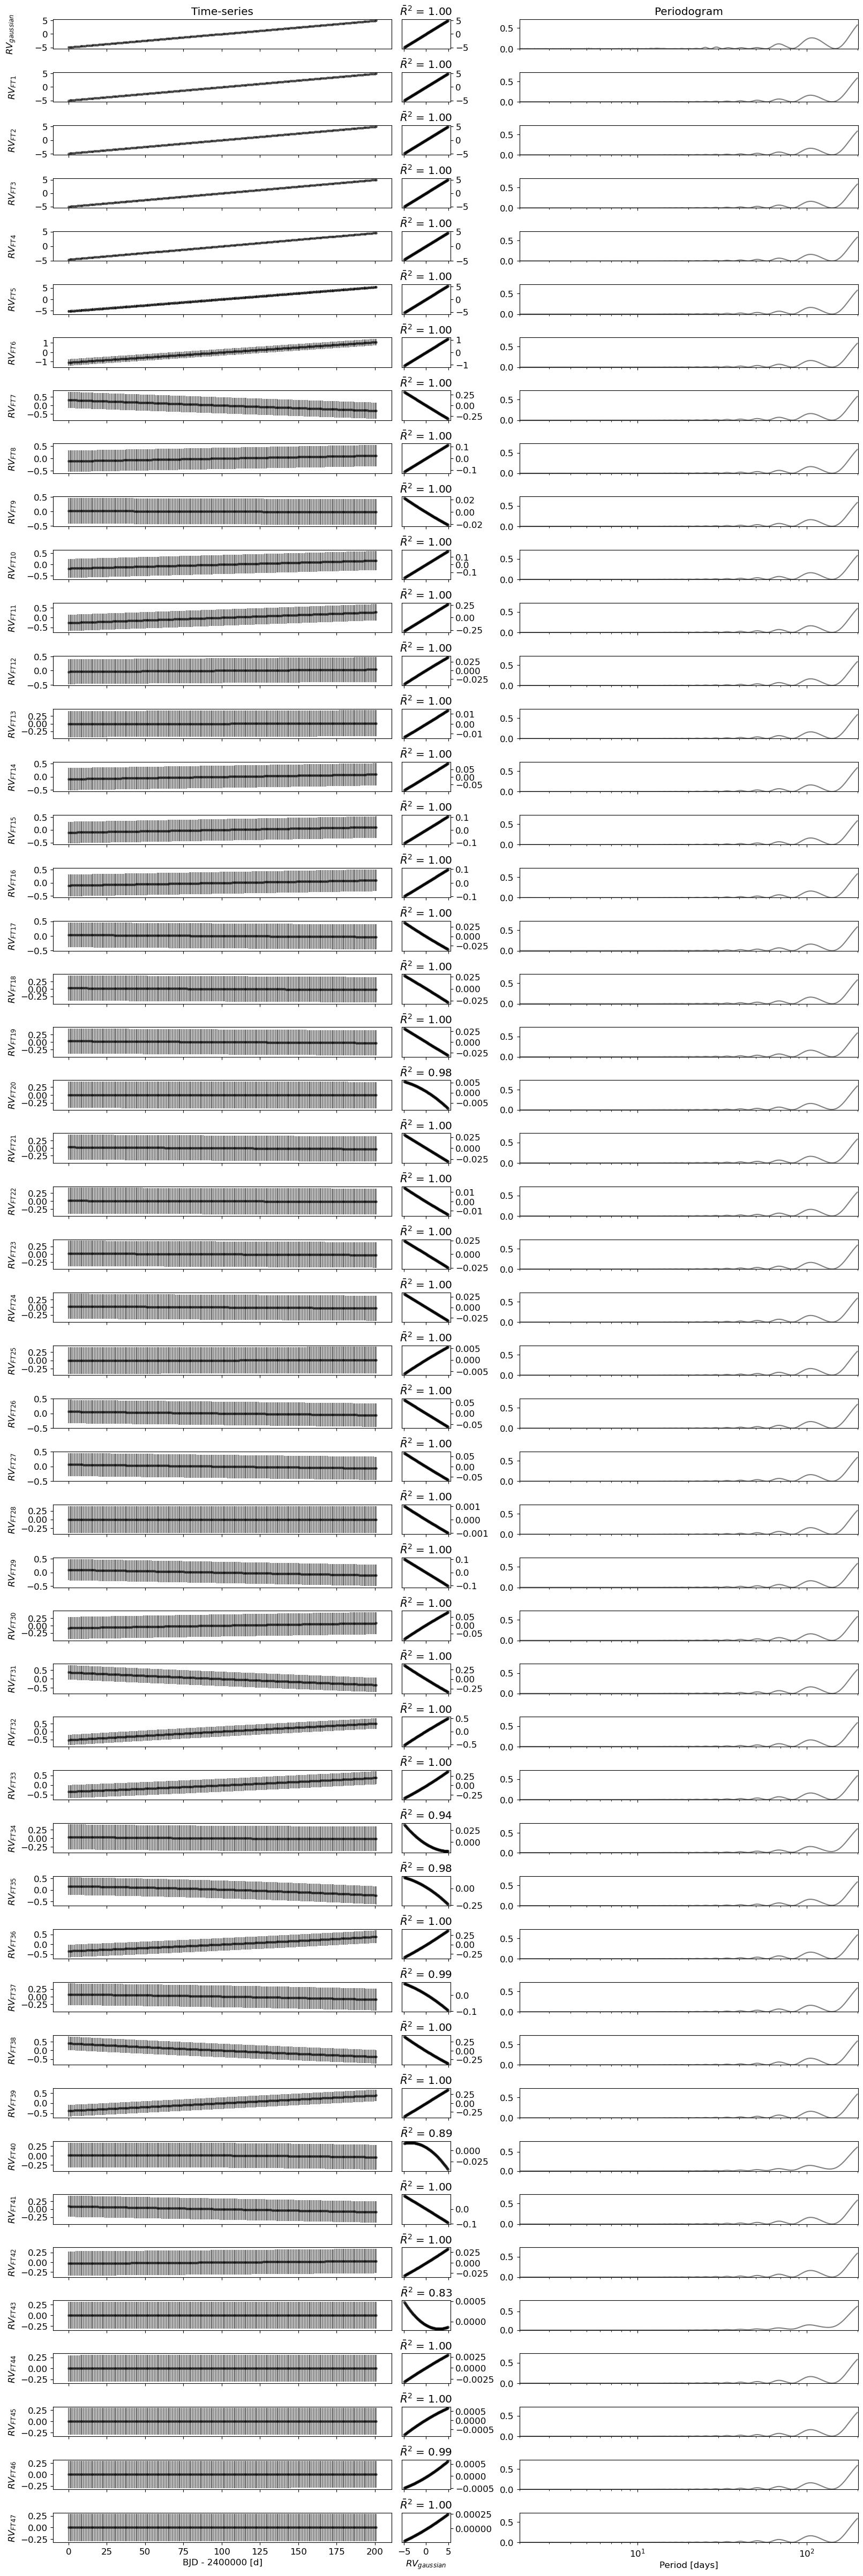

In [15]:
plot_all(k_mode=k_max, t=np.arange(202), rv=RV_gauss, erv=σrv_daily, 
    ind=RV_FT_k, eind=eRV_FT_k, 
    ts_xlabel='BJD - 2400000 [d]', 
    rv_xlabel='$RV_{gaussian}$', 
    pe_xlabel='Period [days]',
    ind_yalbel=r'$RV_{FT}$',
    file_name='',
    HARPS=False)
plt.show()

In [16]:
[max(RV_FT_k[i])-min(RV_FT_k[i]) for i in range(47) ]

[9.957755948301646,
 9.922751026790614,
 10.046017772415091,
 9.212475344505783,
 10.680507551565782,
 2.160630563551381,
 0.6267591907133949,
 0.23121363098656222,
 0.04371947713588348,
 0.35346973916706725,
 0.541856001356009,
 0.0779349234184736,
 0.027241619855430263,
 0.17852005126289033,
 0.2135179649437932,
 0.19783090549008614,
 0.07074126808476619,
 0.05673336903591707,
 0.06311290474247268,
 0.013225572002235229,
 0.06150911969880905,
 0.028711875522935963,
 0.049477544853017294,
 0.0637362043638671,
 0.011657035627490136,
 0.12144754261839677,
 0.12981448220404948,
 0.002029981956239287,
 0.20691148490658534,
 0.16162952552218485,
 0.7088781295023543,
 1.039337882620354,
 0.7179736173799656,
 0.05719465846649103,
 0.4014633975913385,
 0.724845348990119,
 0.1705724095702103,
 0.7683809379379942,
 0.756399490237313,
 0.06125893993475985,
 0.18264718469828672,
 0.06494937668486753,
 0.0006624655496349585,
 0.006069885075180324,
 0.001500352985126375,
 0.0011044993167467145,
 0.

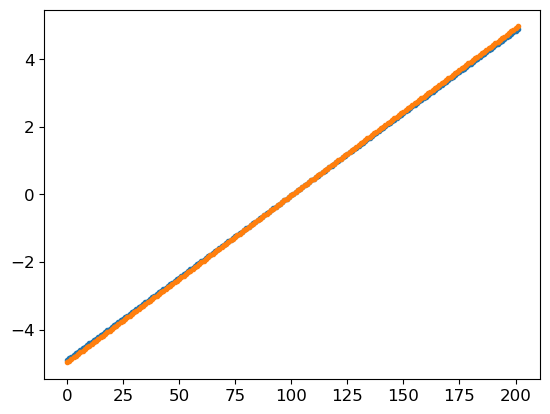

In [15]:
plt.plot(RV_FIESTA, '.', label='fiesta')
plt.plot(RV_gauss, '.', label='gaussian')
plt.show()

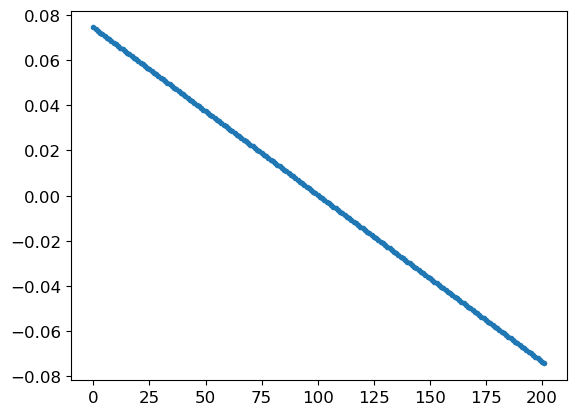

In [16]:
plt.plot(RV_FIESTA-RV_gauss, '.', label='gaussian')
plt.show()

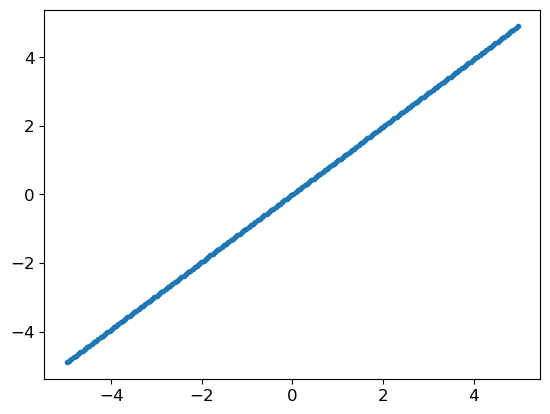

In [55]:
plt.plot(RV_gauss, RV_FIESTA, '.')
plt.show()

In [17]:
np.std(RV_FIESTA-RV_gauss), np.std(RV_FIESTA), np.std(RV_gauss)

(0.04320040803091624, 2.8441557020726265, 2.887356098564402)

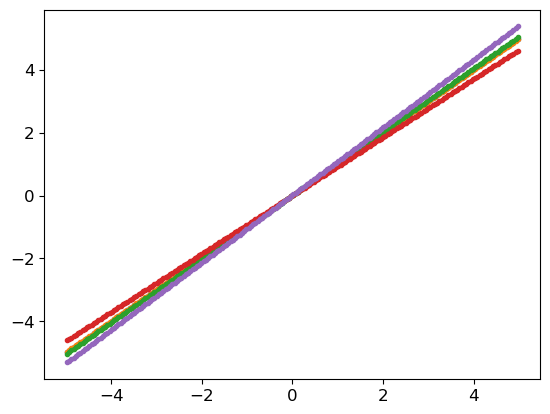

In [22]:
plt.plot(RV_gauss, RV_FT_k[0:5].T, '.')
plt.show()

In [ ]:
plt.plot(A_k[:10,], '.')
plt.show()

In [21]:
RV_FT_k.shape

(47, 202)